# Анализ данных

## Библиотеки и модули

Загрузка библиотек и модулей, используемых при анализе данных. 
- Модель: **LGBMClassifier** из библиотеки **LightGBM** для оценки значимости признаков в модели
- Предобработчик данных для модели: **DataPreprocessor** (из модуля **helper.data**)
- Борьба с дисбалансом классов: **RandomOverSampler** (библиотека **imbalanced-learn**)
- Разделение на тренировочную и тестовую выборки, кросс-валидация, оценка решения: 
    - библиотека **scikit-learn**
    - **valid_predictions** (из модуля **helper.validation**)
- Работа с датасетом: библиотека **pandas** 
- Работа с файловой системой: модуль **os**
- Визуализация: **matplotlib**, **seaborn**, **plotly-express**

In [1]:
# Модели
from lightgbm import LGBMClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from hyperparameters.helpers.data import RENAME_COLS

# Инструменты для анализа данных
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import shap

# Система
import os

# Настройки вывода
import warnings
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
pd.set_option('display.max_columns', None)
%matplotlib inline

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Загрузка датасетов

In [2]:
# Пути
ROOT = os.getcwd()
TRAIN_DATASET = os.path.join(ROOT, 'data/train_AIC.csv')
TEST_DATASET = os.path.join(ROOT, 'data/test_AIC.csv')

# Загружаем датасеты
train_df = pd.read_csv(TRAIN_DATASET)
test_df = pd.read_csv(TEST_DATASET)
train_df = train_df.drop_duplicates()

# Удаление дубликатов из тренировочной выборки
train_df = train_df.drop_duplicates()

In [38]:
# Случайные записи тренировочного датасета
train_df.sample(10, random_state=42)

,Поставщик,Материал,Категорийный менеджер,Операционный менеджер,Завод,Закупочная организация,Группа закупок,Балансовая единица,ЕИ,Группа материалов,Вариант поставки,НРП,Длительность,До поставки,Месяц1,Месяц2,Месяц3,День недели 2,Сумма,Количество позиций,Количество,Количество обработчиков 7,Количество обработчиков 15,Количество обработчиков 30,Согласование заказа 1,Согласование заказа 2,Согласование заказа 3,Изменение даты поставки 7,Изменение даты поставки 15,Изменение даты поставки 30,Отмена полного деблокирования заказа на закупку,Изменение позиции заказа на закупку: изменение даты поставки на бумаге,Изменение позиции заказа на закупку: дата поставки,Количество циклов согласования,Количество изменений после согласований,Дней между 0_1,Дней между 1_2,Дней между 2_3,Дней между 3_4,Дней между 4_5,Дней между 5_6,Дней между 6_7,Дней между 7_8,y
177605,27,1663,1,12,2,2,23,2,2,24,2,0.0,67,67,11,1,11,2,5.601229,9,50.0,5,5,6,1,1,1,0.0,0.0,0.0,0,0,0,1.0,10,16.0,1.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,0
31902,1,3246,2,3,8,1,16,7,1,13,1,0.0,57,21,5,7,5,2,5.429935,1,8.0,5,5,5,1,1,1,0.0,0.0,0.0,0,0,0,1.0,8,1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,0
104706,17,5307,2,3,1,1,43,1,1,6,2,0.0,63,63,8,10,8,5,5.879904,2,4.0,6,6,6,1,1,1,0.0,0.0,0.0,0,0,0,1.0,9,58.0,0.0,0.0,3.0,0.0,-1.0,-1.0,-1.0,0
173943,101,4277,1,6,1,1,39,1,1,47,1,0.0,120,120,1,5,2,4,5.732279,3,8.0,9,9,10,1,1,1,7.0,7.0,7.0,0,3,3,1.0,0,18.0,0.0,0.0,0.0,0.0,-1.0,-1.0,35.0,0
35428,17,1018,1,12,2,2,133,2,1,1,2,1.0,40,27,12,1,12,3,5.689572,13,1.0,6,6,6,1,1,1,1.0,1.0,1.0,0,1,1,1.0,12,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,0
82163,2,399,10,18,1,8,31,1,1,32,2,1.0,13,13,5,6,5,2,4.554133,27,10.0,5,5,5,2,1,1,0.0,0.0,0.0,0,0,0,1.0,13,0.0,0.0,7.0,0.0,0.0,-1.0,-1.0,-1.0,0
15887,16,27439,4,5,1,1,60,1,1,58,1,0.0,45,45,12,1,12,0,6.352330,1,8.0,8,8,8,1,1,1,0.0,0.0,0.0,0,0,0,1.0,12,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,0
103317,75,27439,1,4,1,1,1,1,2,9,2,1.0,32,27,4,5,4,2,5.581203,5,3.4,9,9,9,1,1,1,5.0,5.0,5.0,0,2,2,1.0,0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,5.0,0
94737,169,2174,1,7,1,1,4,1,4,63,2,0.0,82,65,3,5,3,0,6.298811,6,80.0,7,7,7,1,1,1,3.0,3.0,3.0,0,1,1,1.0,12,2.0,0.0,4.0,0.0,0.0,-1.0,-1.0,-1.0,0
179282,693,27439,1,13,6,5,1,5,1,9,2,0.0,60,6,9,11,9,2,3.753406,2,20.0,5,5,5,0,1,0,0.0,0.0,0.0,0,0,0,1.0,9,6.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0


Для начала взглянем на статистику признаков.

In [39]:
# Статистическая характеристика
train_df.describe()

,Поставщик,Материал,Категорийный менеджер,Операционный менеджер,Завод,Закупочная организация,Группа закупок,Балансовая единица,ЕИ,Группа материалов,Вариант поставки,НРП,Длительность,До поставки,Месяц1,Месяц2,Месяц3,День недели 2,Сумма,Количество позиций,Количество,Количество обработчиков 7,Количество обработчиков 15,Количество обработчиков 30,Согласование заказа 1,Согласование заказа 2,Согласование заказа 3,Изменение даты поставки 7,Изменение даты поставки 15,Изменение даты поставки 30,Отмена полного деблокирования заказа на закупку,Изменение позиции заказа на закупку: изменение даты поставки на бумаге,Изменение позиции заказа на закупку: дата поставки,Количество циклов согласования,Количество изменений после согласований,Дней между 0_1,Дней между 1_2,Дней между 2_3,Дней между 3_4,Дней между 4_5,Дней между 5_6,Дней между 6_7,Дней между 7_8,y
count,220342.000000,220342.000000,220342.000000,220342.000000,220342.000000,220342.000000,220342.000000,220342.000000,220342.000000,220342.000000,220342.000000,220342.000000,220342.000000,220342.000000,220342.00000,220342.000000,220342.000000,220342.000000,220342.000000,220342.000000,220342.000000,220342.000000,220342.000000,220342.000000,220342.000000,220342.000000,220342.000000,220342.000000,220342.000000,220342.000000,220342.000000,220342.000000,220342.000000,220342.000000,220342.000000,220342.000000,220342.000000,220342.000000,220342.000000,220342.000000,220342.000000,220342.000000,220342.000000,220342.000000
mean,257.174924,12179.739755,2.490987,7.370987,4.113746,3.001938,46.510688,2.707727,1.658744,25.636942,1.652776,0.312886,58.396148,47.984569,6.54257,6.282098,6.404685,2.722981,6.029473,14.275467,350.204859,7.058940,7.177283,7.261888,1.577602,1.427504,1.174229,1.564550,1.568339,1.570785,0.470133,0.589452,0.613669,1.392227,13.998162,11.488985,1.649858,0.976623,0.168801,0.005646,-0.389463,-0.550603,1.643132,0.143953
std,431.087116,11026.107644,2.320434,5.566062,6.027087,3.648353,56.709336,3.074474,1.628628,28.098157,0.496262,0.464061,43.579565,40.067584,3.59556,3.373563,3.555460,1.825841,1.145611,23.221356,5670.757005,2.019189,2.018758,2.014442,1.489433,1.028813,0.973788,2.561923,2.566687,2.570338,0.969584,1.050705,1.042153,0.974461,33.117008,28.663269,8.976600,5.997171,2.799125,2.421106,6.177057,5.440240,13.953111,0.351043
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.00000,1.000000,1.000000,0.000000,0.485452,1.000000,0.001000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,14.000000,1600.000000,1.000000,3.000000,1.000000,1.000000,7.000000,1.000000,1.000000,6.000000,1.000000,0.000000,30.000000,21.000000,3.00000,3.000000,3.000000,1.000000,5.267620,3.000000,2.000000,6.000000,6.000000,6.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,81.000000,8261.000000,1.000000,6.000000,1.000000,1.000000,22.000000,1.000000,1.000000,15.000000,2.000000,0.000000,50.000000,40.000000,7.00000,6.000000,6.000000,3.000000,5.971622,7.000000,6.000000,7.000000,7.000000,7.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,13.000000,2.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000
75%,297.000000,27439.000000,3.000000,11.000000,5.000000,3.000000,66.000000,3.000000,1.000000,36.000000,2.000000,1.000000,76.000000,64.000000,10.00000,9.000000,10.000000,4.000000,6.745308,16.000000,28.000000,8.000000,8.000000,8.000000,2.000000,2.000000,1.000000,3.000000,3.000000,3.000000,1.000000,1.000000,1.000000,2.000000,18.000000,9.000000,0.000000,1.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000
max,2720.000000,27439.000000,15.000000,38.000000

Можно заметить выбросы в признаках **"Длительность"**, **"До поставки"**, **"Число изменений после согласований"** и **"Количество"** которые потребуют рассмотрения.

Оценим размерность данных и их полноту (отсутствие пропущенных значений).

In [12]:
# Размерность данных
print(f'Размерность train_df: {train_df.shape}')
print(f'Размерность test_df: {test_df.shape}')

# Оценка полноты данных (NaN значения)
print(f'Число пропущенных значений train_df: {train_df.isna().sum().sum()}')
print(f'Число пропущенных значений test_df: {test_df.isna().sum().sum()}')

Размерность train_df: (220342, 44)
Размерность test_df: (25000, 43)
Число пропущенных значений train_df: 0
Число пропущенных значений test_df: 0


Как видим, данные достаточно объёмные, однако пропущенных значений в них не имеется.

Посмотрим на распределение классов.

In [18]:
print(f'Распределение классов:\n{train_df["y"].value_counts()}\n')

Распределение классов:
y
0    188623
1     31719
Name: count, dtype: int64



Заметен сильный перекос в сторону негативных записей (отсутствие срыва), это необходимо учитывать при построении модели.

## Распределения признаков

Мы можем посмотреть на распределения признаков, чтобы понять, какие значения чаще всего встречаются в наших данных и, возможно, отсеить категорильнае признаки, имеющие сильный дисбаланс в распределении значений.

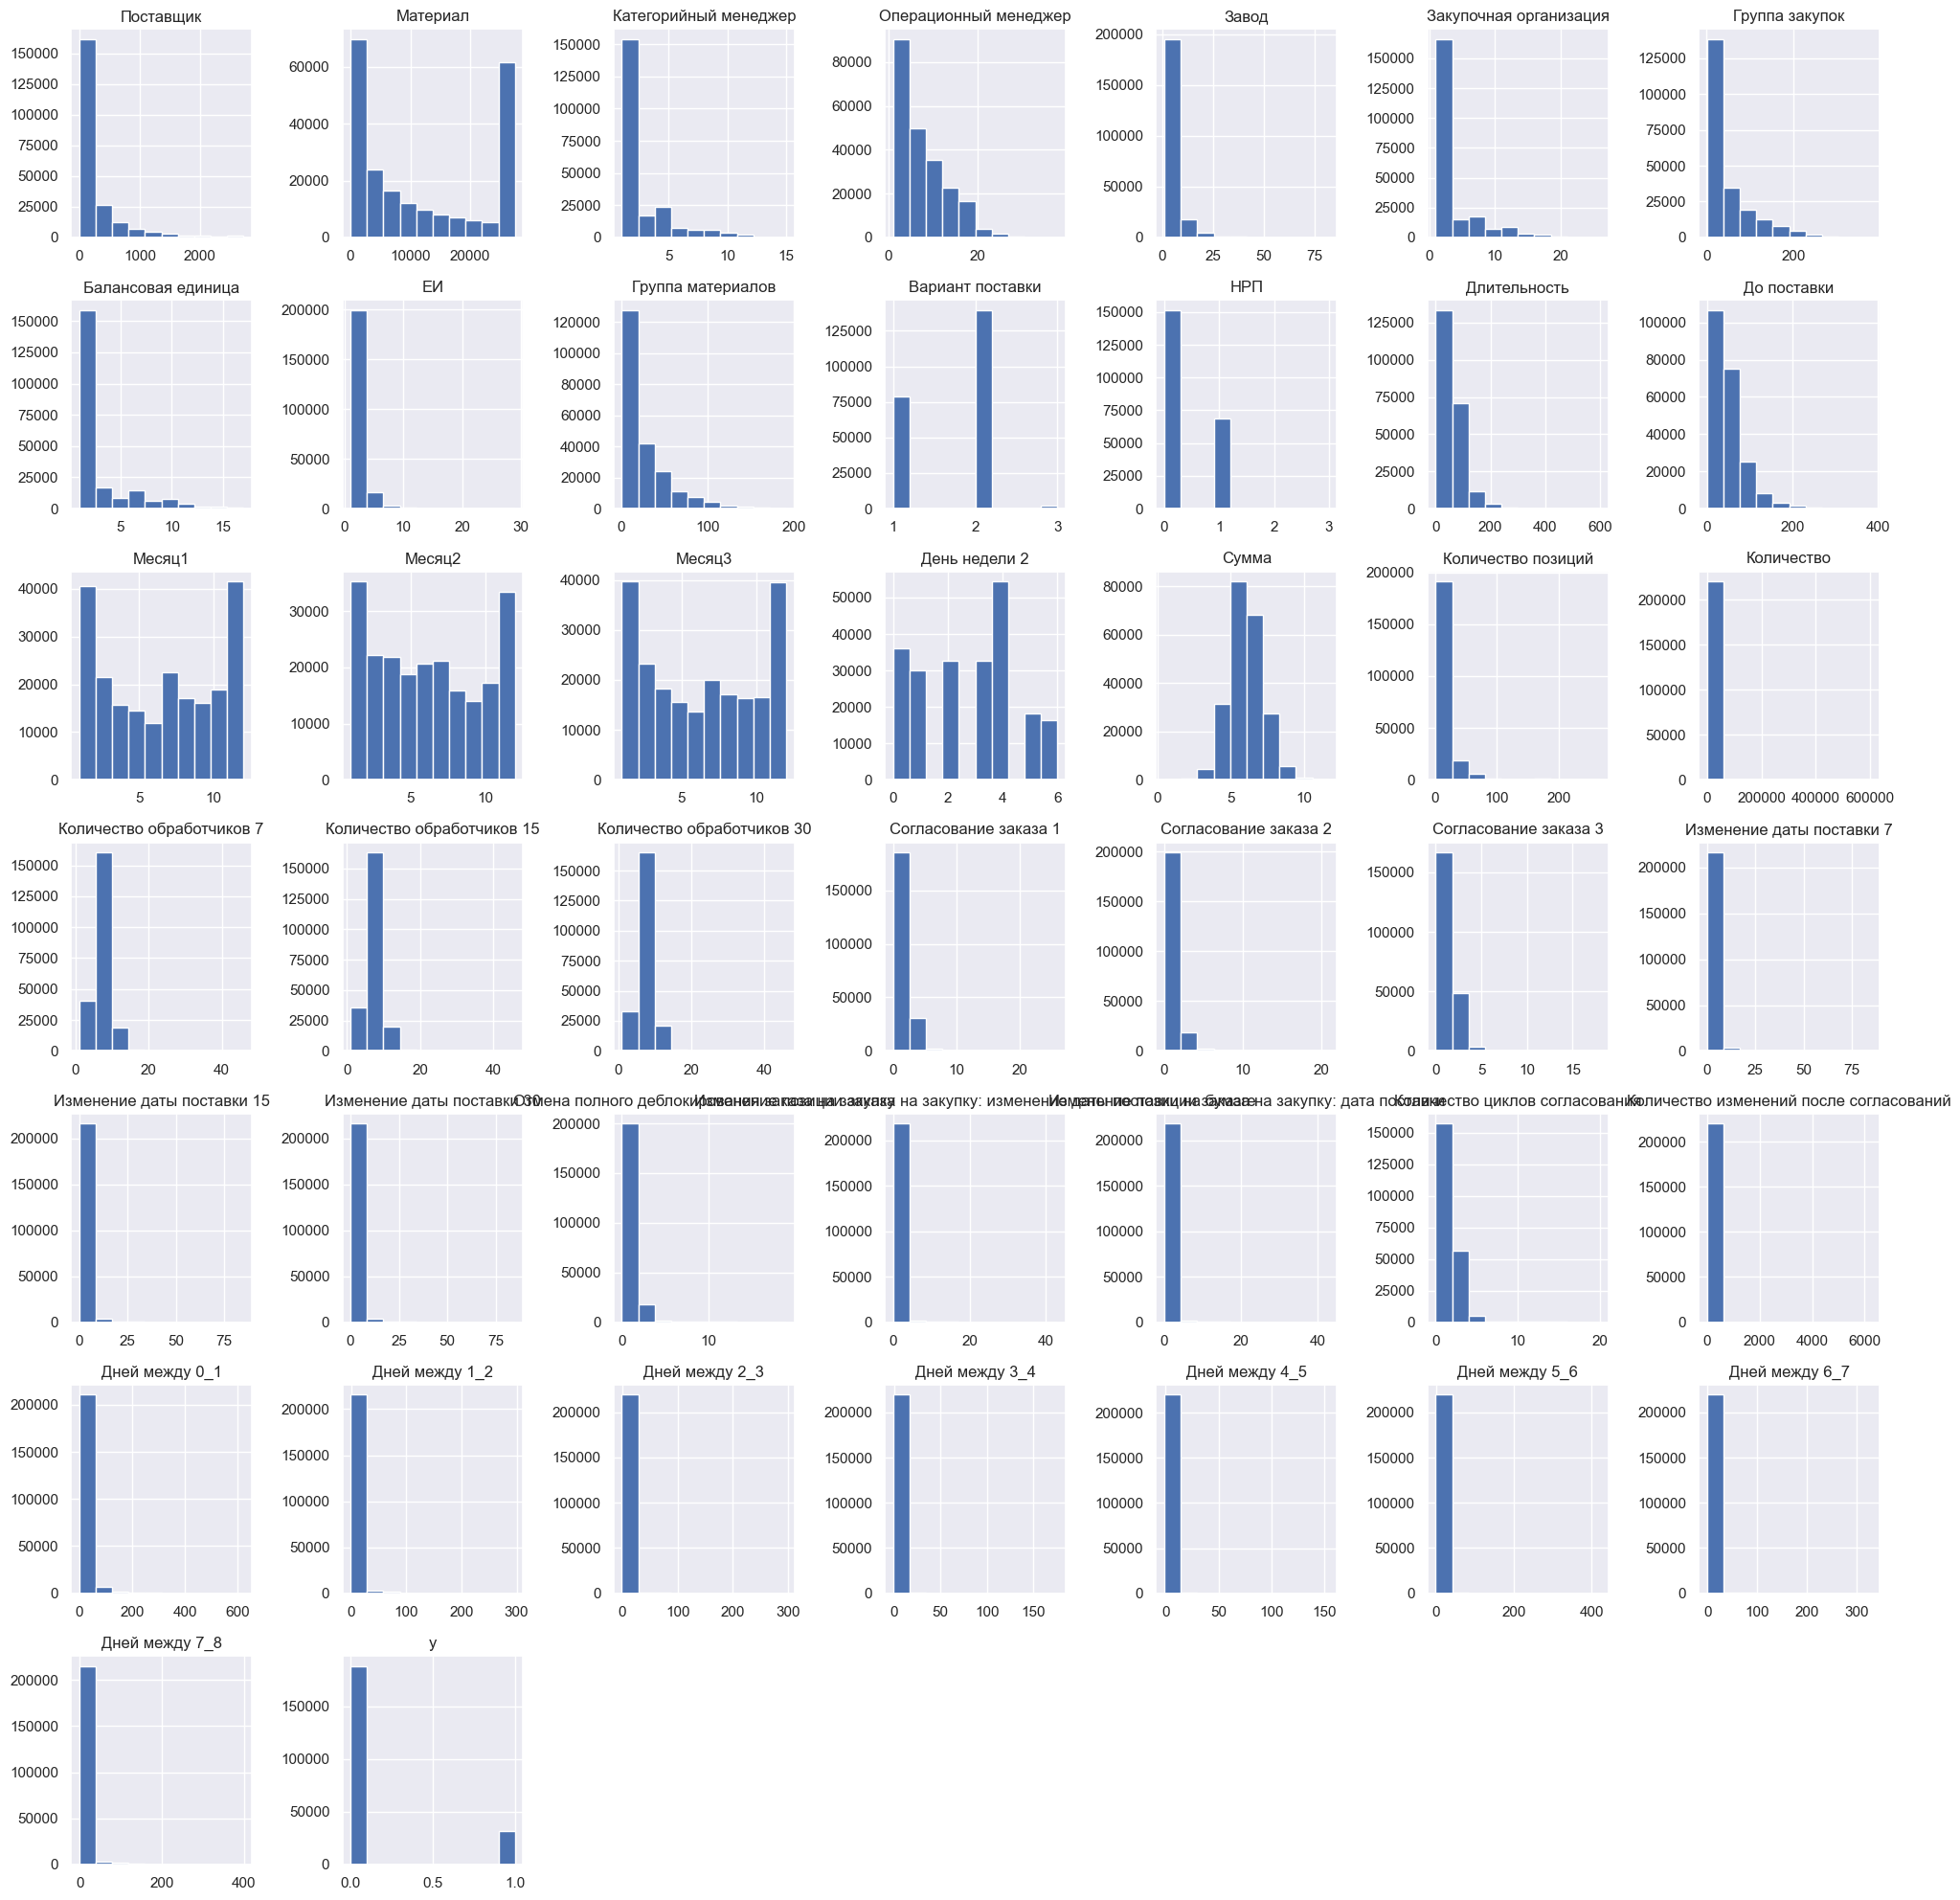

In [68]:
train_df.hist(figsize=(20, 20))
plt.tight_layout()

Исходя из данных диаграмм, особое внимание стоит уделить признакам **"НРП"**, **"Вариант поставки"** и **"ЕИ"**, чтобы оценить их значимость и влияние на работу модели.

## Матрица корреляции

Для первичной оценки признаков, мы можем построить матрицу корреляции. Это даст первичное представление о важности признаков, однако опираться лишь на матрицу корреляции нельзя, посколько она не учитывает возможные сильные взаимосвязи между целевым классом и комбинацией каких-то признаков.

In [31]:
# Строим матрицу корреляции
fig = px.imshow(train_df.corr(), width=1500, height=1200)
fig.show()

Видна корреляция целевого класса со следующими признаками: Поставщик, Материал, Завод, Закупочная организация, ЕИ, Группа закупок, Вариант поставки, Длительность, Месяц (1, 2, 3), Сумма, Количество обработчиков (7, 15, 30). Возможно, что корреляция с категориальными признаками переоценена, поэтому оценивать их значимость лучше в ходе тестирования модели. Имеет смысл представить временные и цикличные признаки в качестве тригонометрических значений (sin/cos), кодировать категориальные признаки с большим диапазоном значений, масштабировать числовые признаки.

## Поставщик
Поставщик, возможно, является одним из важнейших признаков, поэтому необходимо оценить распределение этого признака и оценить взаимосвязь между поставщиком и срывом поставок.

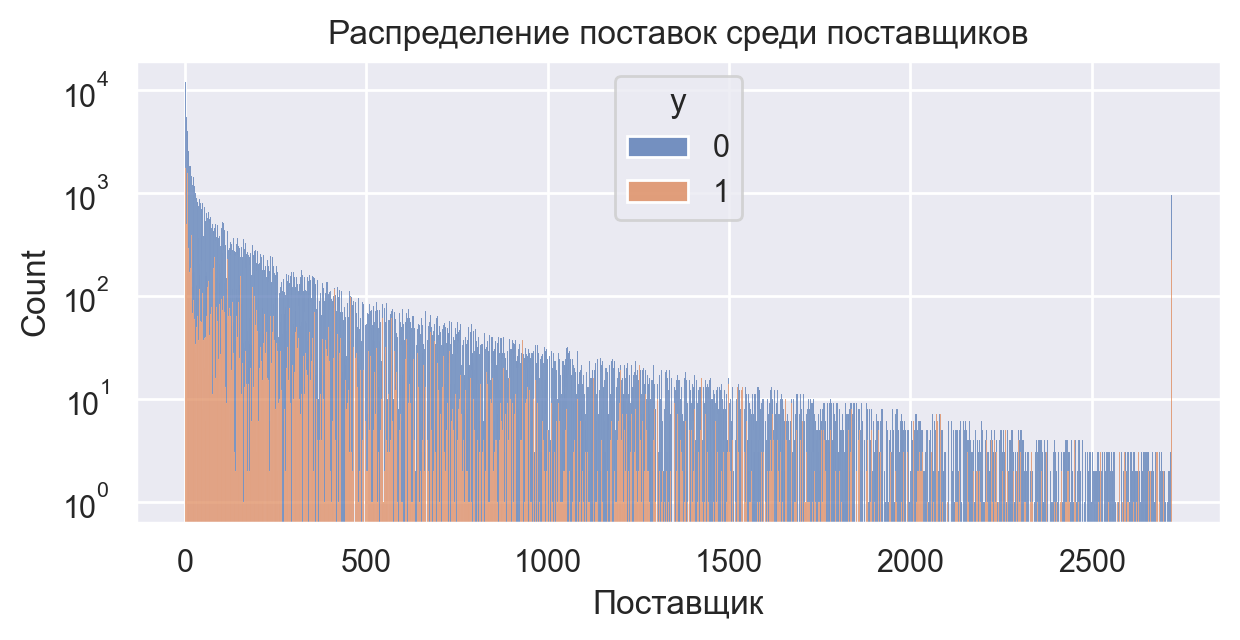

In [32]:
# Распределение поставок среди поставщиков
plt.figure(figsize=(7, 3), dpi=200)
sns.set(font_scale=1)
sns.histplot(data=train_df, x='Поставщик', hue='y', multiple='stack', binwidth=1)
plt.title('Распределение поставок среди поставщиков')
plt.yscale('log')
plt.show()

Из графика видно, что разные поставщики имеют разное число срывов и соотношение числа срывов к общему числу поставок, поэтому этот признак целесообразно использовать при построении модели. Возможно это связано с разными местоположениями поставщиков, способами поставки материалов, а также штатом сотрудников, которые работают на поставщика и материалами, которые поставляет поставщик.

## Материал
Необходимо построить график распределения материалов, чтобы понять, есть ли взаимосвязь между материалом и срывом поставки этого материала.

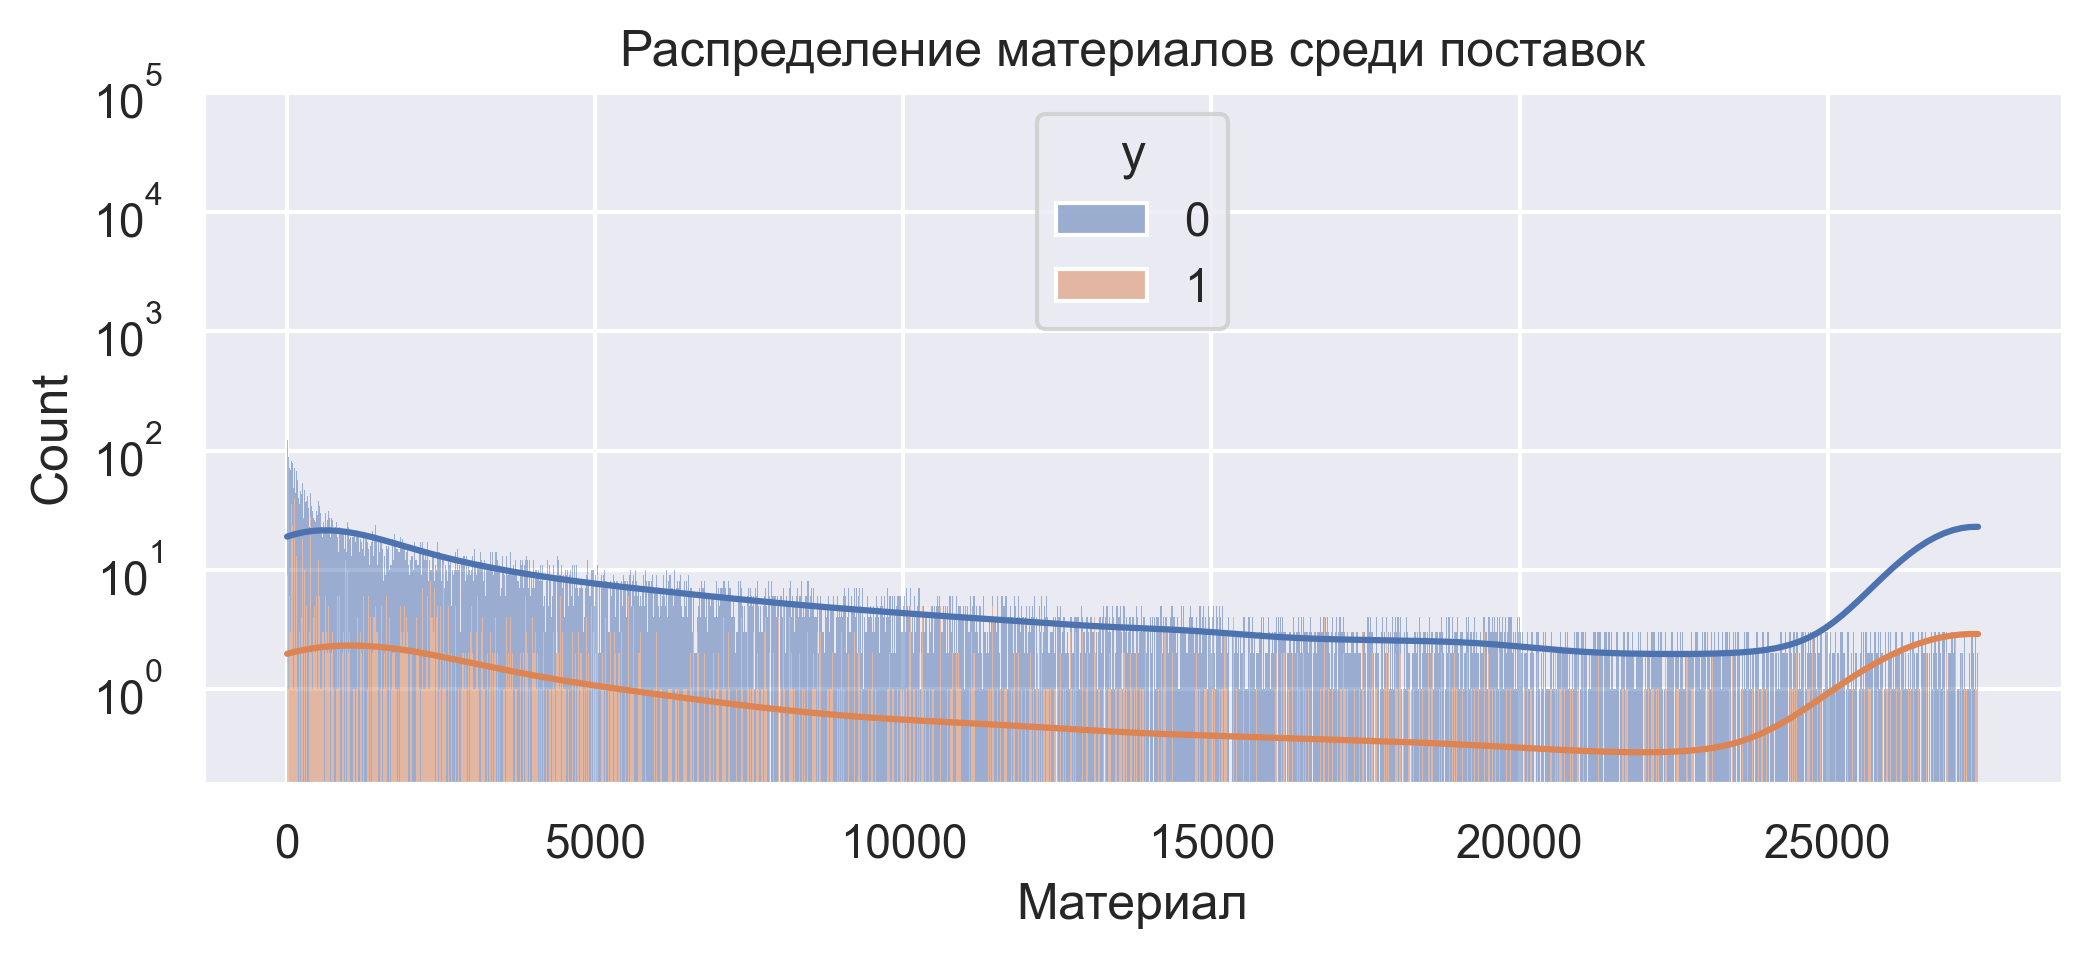

In [34]:
plt.figure(figsize=(8, 3), dpi=300)
sns.histplot(data=train_df, x='Материал', hue='y', multiple='stack', binwidth=1, kde=True)
plt.title('Распределение материалов среди поставок')
plt.yscale('log')
plt.show()

Данный признак будет целесообразно отбросить при построении модели, поскольку эта категория имеет большой диапазон значений, а так же малое число записей для огромного количества материалов. Кроме того, он может создавать шум в данных, из-за чего модель может плохо показать себя в реальных условиях.

## Сумма

Сумма заказа на поставку может играть ключевую роль в исходе сделки, для проверки этой гипотезы мы также построим график распределения этого признака.

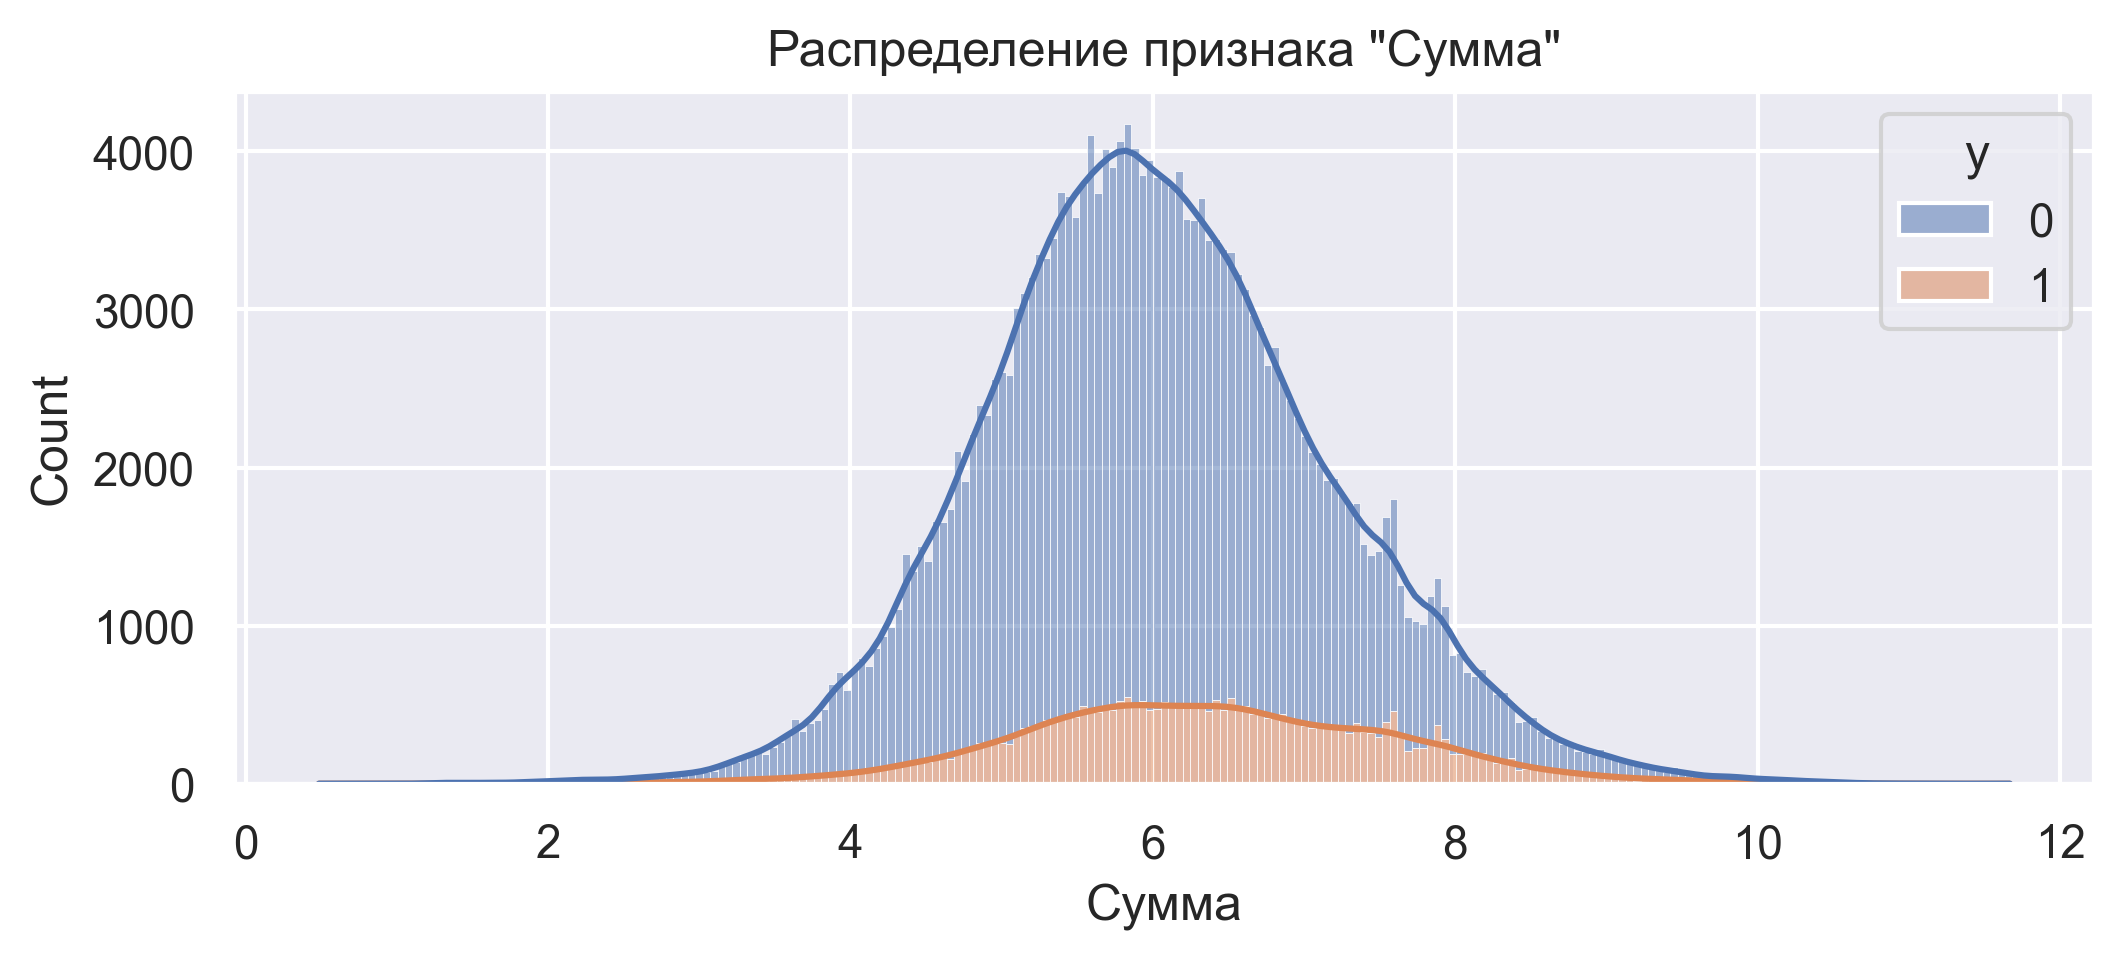

In [35]:
plt.figure(figsize=(8, 3), dpi=300)
sns.histplot(data=train_df, x='Сумма', hue='y', kde=True, multiple='stack')
plt.title('Распределение признака "Сумма"')
plt.show()

Это распределение является нормальным. С ростом суммы поставки растёт процент срывов. Количество поставок на сумму больше 6 начинает плавно уменьшаться, но соотношение успешных к сорванным поставкам растёт. Лишь в особо крупных заказах процент срывов начинает уменьшаться, но можно сделать вывод, что при росте суммы увеличивается и процент срыва. Учитывая матрицу корреляций, мы можем предположить, что сумма играет значительную роль в исходе сделки.

## Длительность
Разница в днях между созданием заказа и планируемым стартом поставок, вероятно, играет большую роль в успехе сделки, а значит поможет модели лучше обнаруживать признаки срыва поставки.

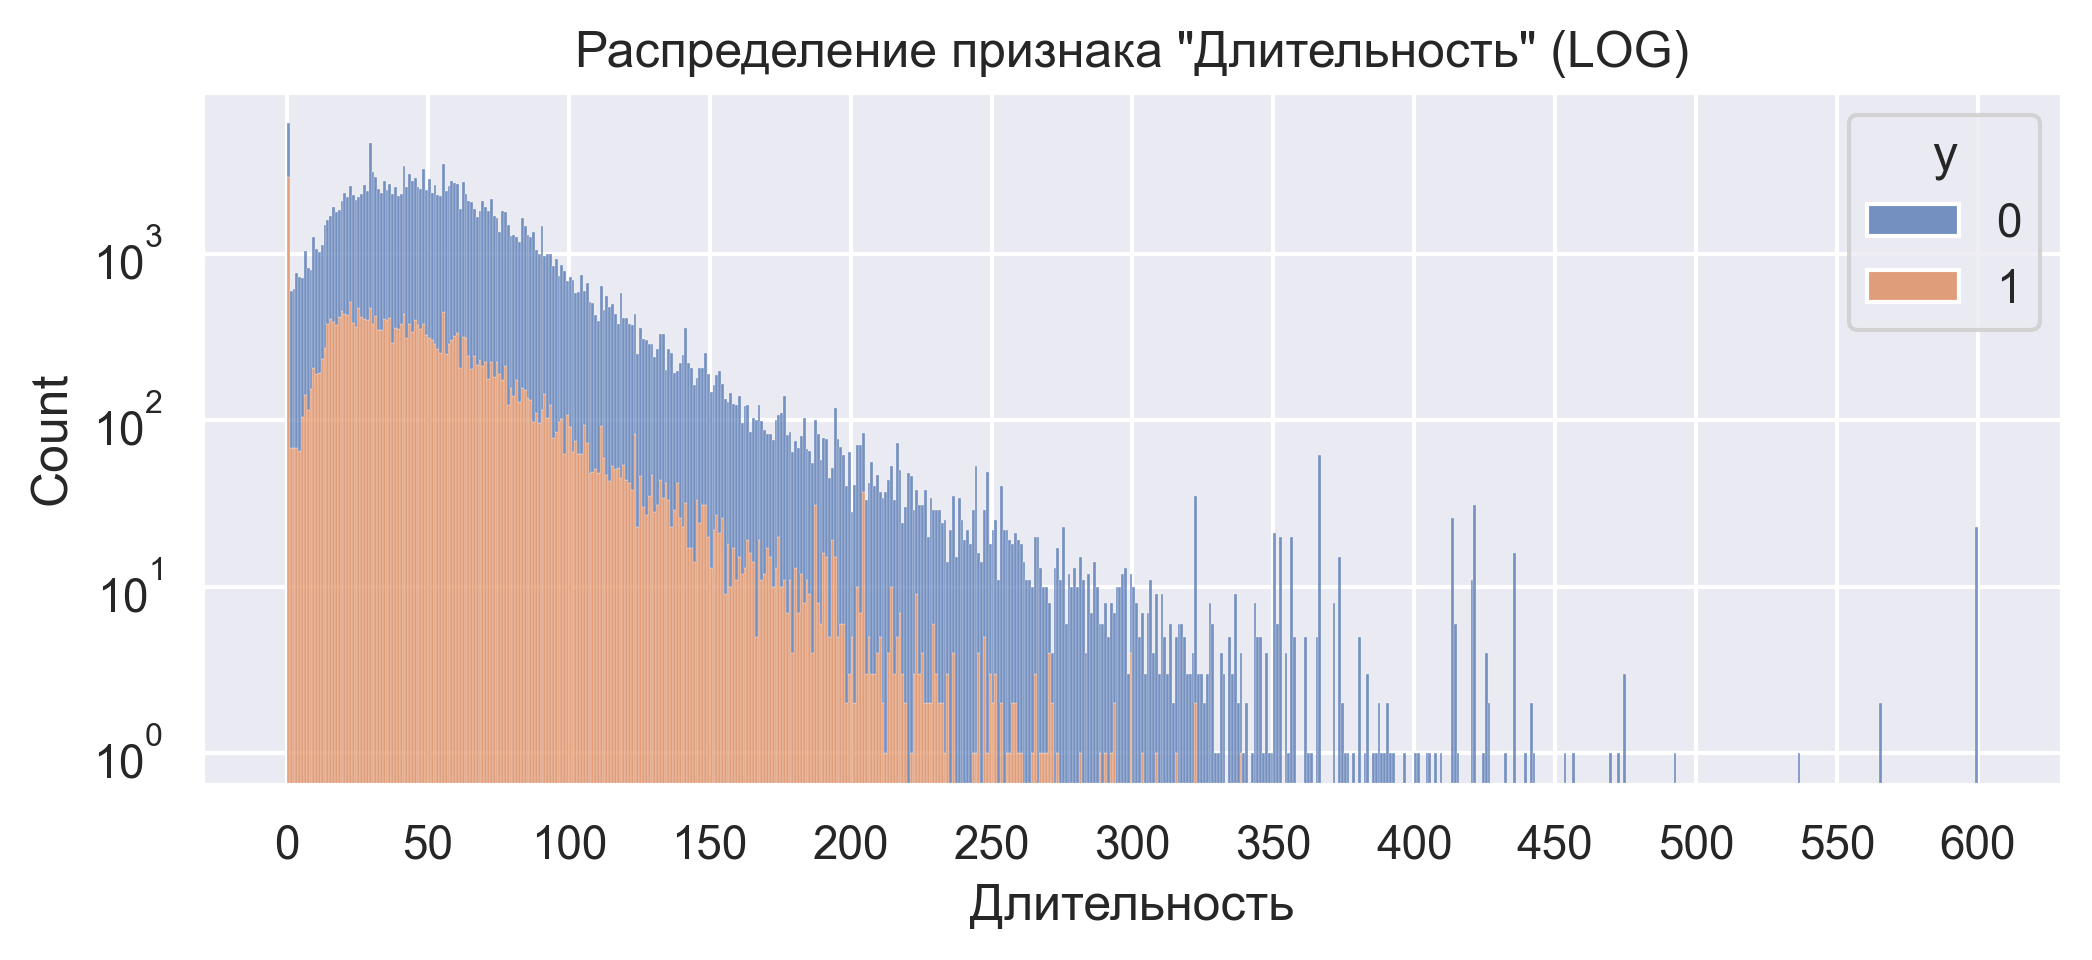

In [41]:
plt.figure(figsize=(8, 3), dpi=300)
sns.histplot(data=train_df, x='Длительность', hue='y', multiple='stack', binwidth=1)
plt.title('Распределение признака "Длительность" (LOG)')
plt.xticks([num for num in range(0, 601, 50)])
plt.yscale('log')
plt.show()

Из графика видно, что число срывов при разнице в днях между созданием заказа и планируемым стартом поставок более 250 число срывов постепенно падает. Поставки, планируемые в длительной перспективе, более надёжны, чем в кратковременной.

## До поставки
Минимум между фактическим поступлением и запланируемым поступлением (длительностью) имеет большое значение, ведь поставка совершённая раньше намеченного срока, скорее всего, ведёт к завершению сделки успехом, в отличие от заказов, пришедших позже планируемого срока.

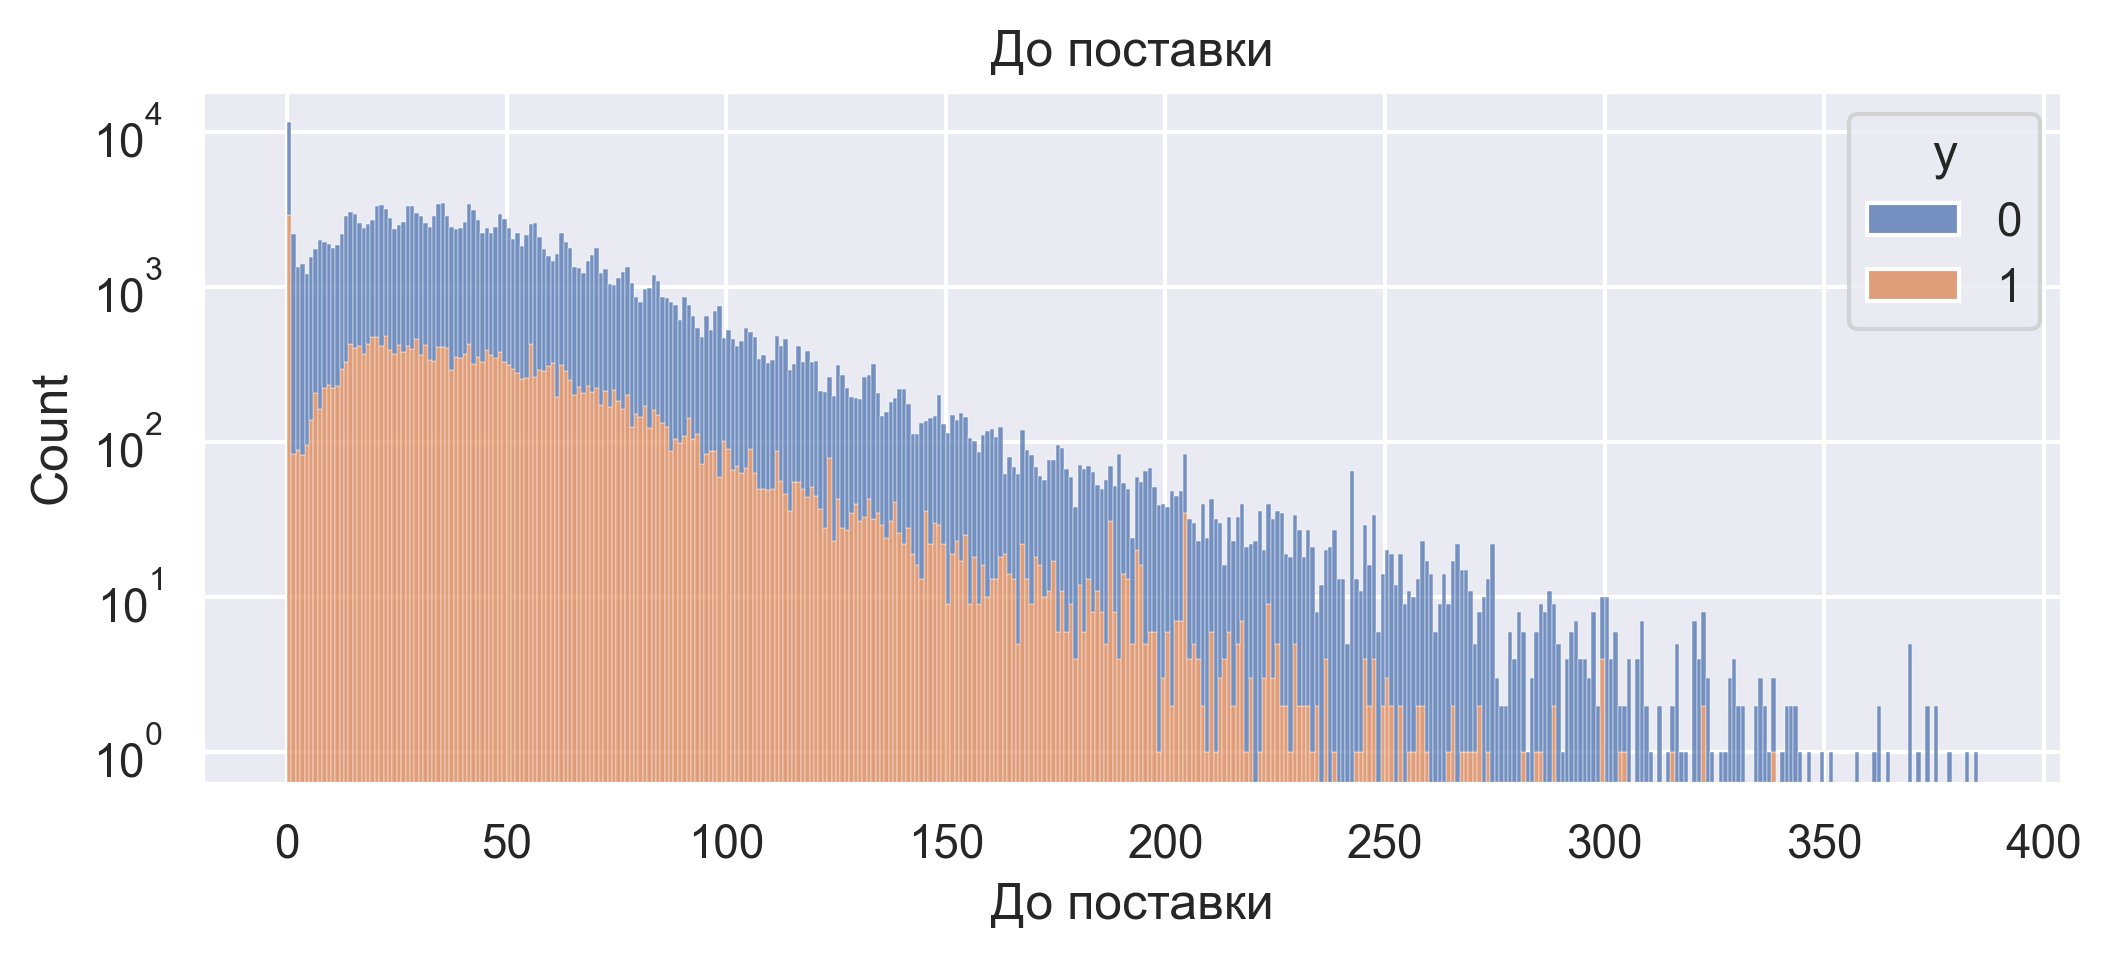

In [46]:
plt.figure(figsize=(8, 3), dpi=300)
sns.histplot(data=train_df, x='До поставки', hue='y', multiple='stack', binwidth=1)
plt.title('До поставки')
plt.yscale('log')
plt.show()

Теперь посмотрим, что будет, если мы возьмём разница между запланированным числом дней до поставки и фактическим числом дней до поставки.

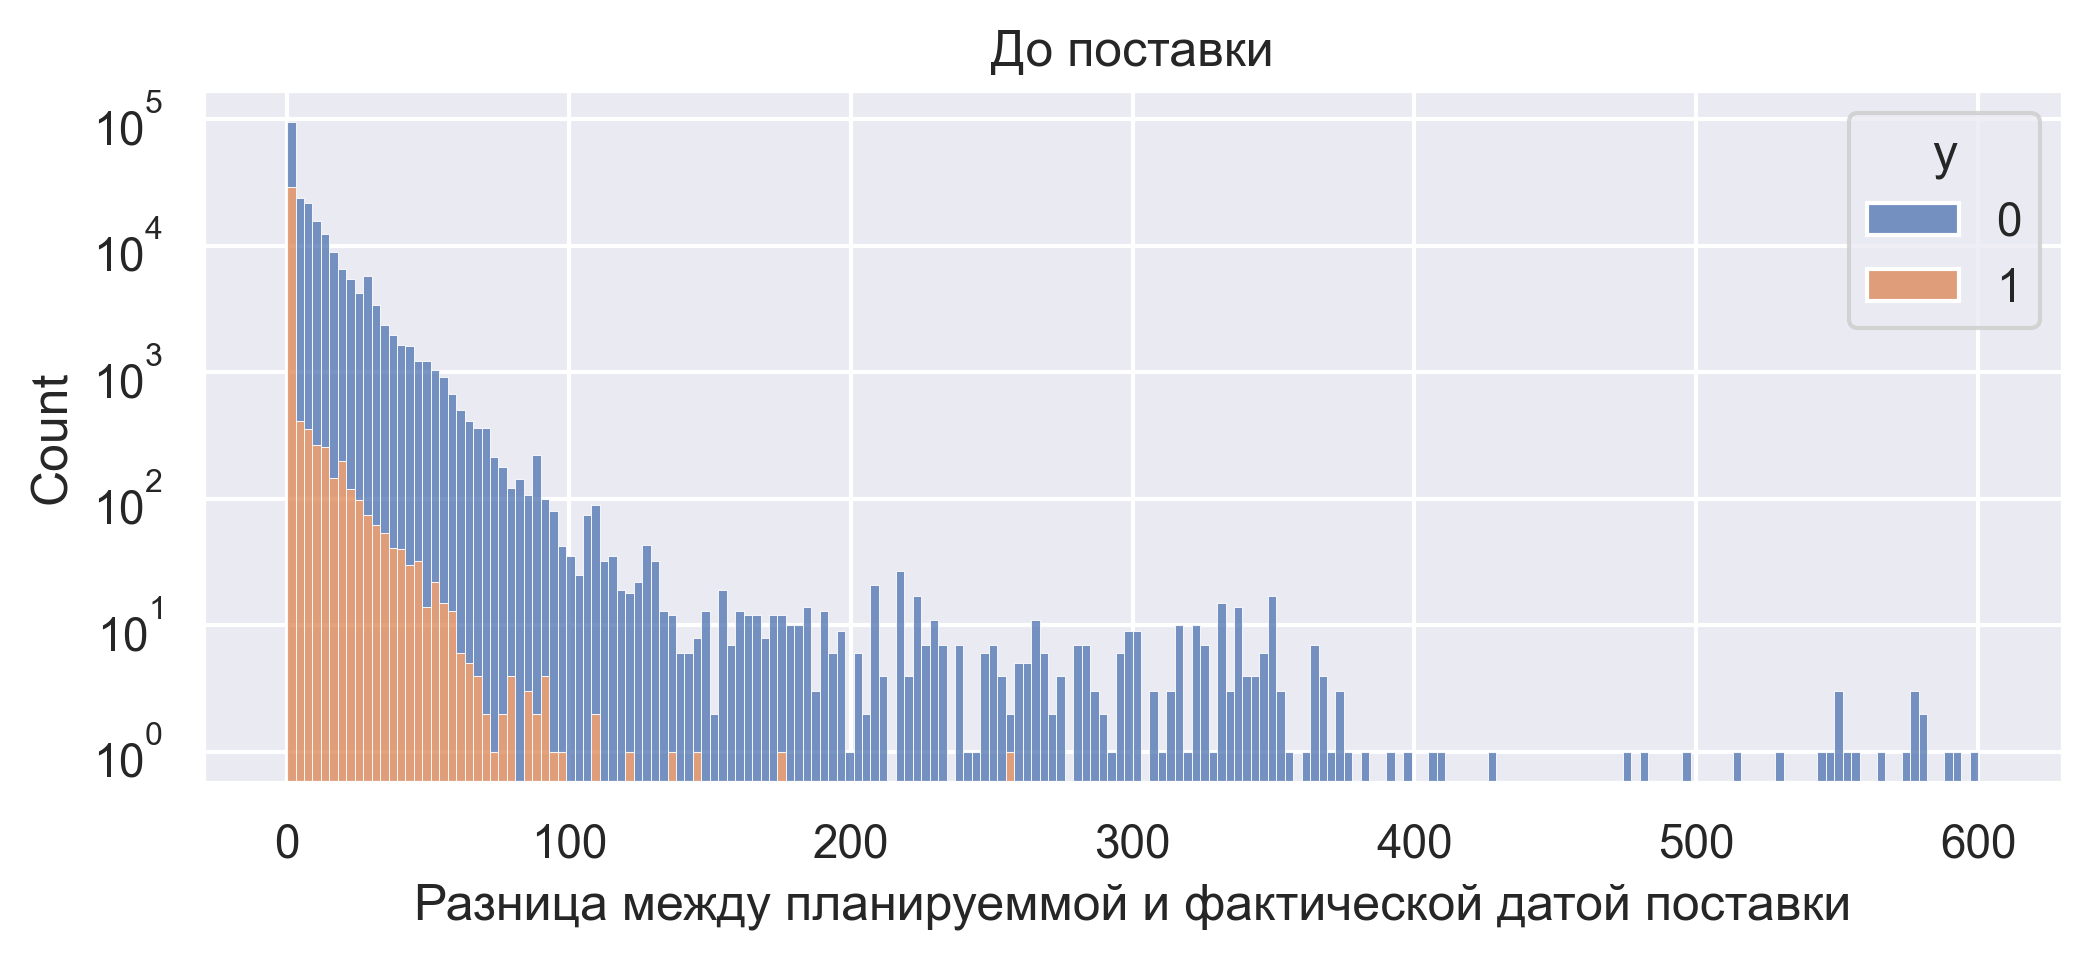

In [73]:
duration_diff = train_df['Длительность'] - train_df['До поставки']
duration_diff = pd.DataFrame({'Разница между планируеммой и фактической датой поставки': duration_diff, 'y': train_df['y']})
plt.figure(figsize=(8, 3), dpi=300)
sns.histplot(data=duration_diff, x=duration_diff.iloc[:, 0], hue='y', multiple='stack', binwidth=3)
plt.title('До поставки')
plt.yscale('log')
plt.show()

Мы смогли экстрагировать новый признак, который сможет помочь нашей модели лучше различать классы.

## Выбросы в данных

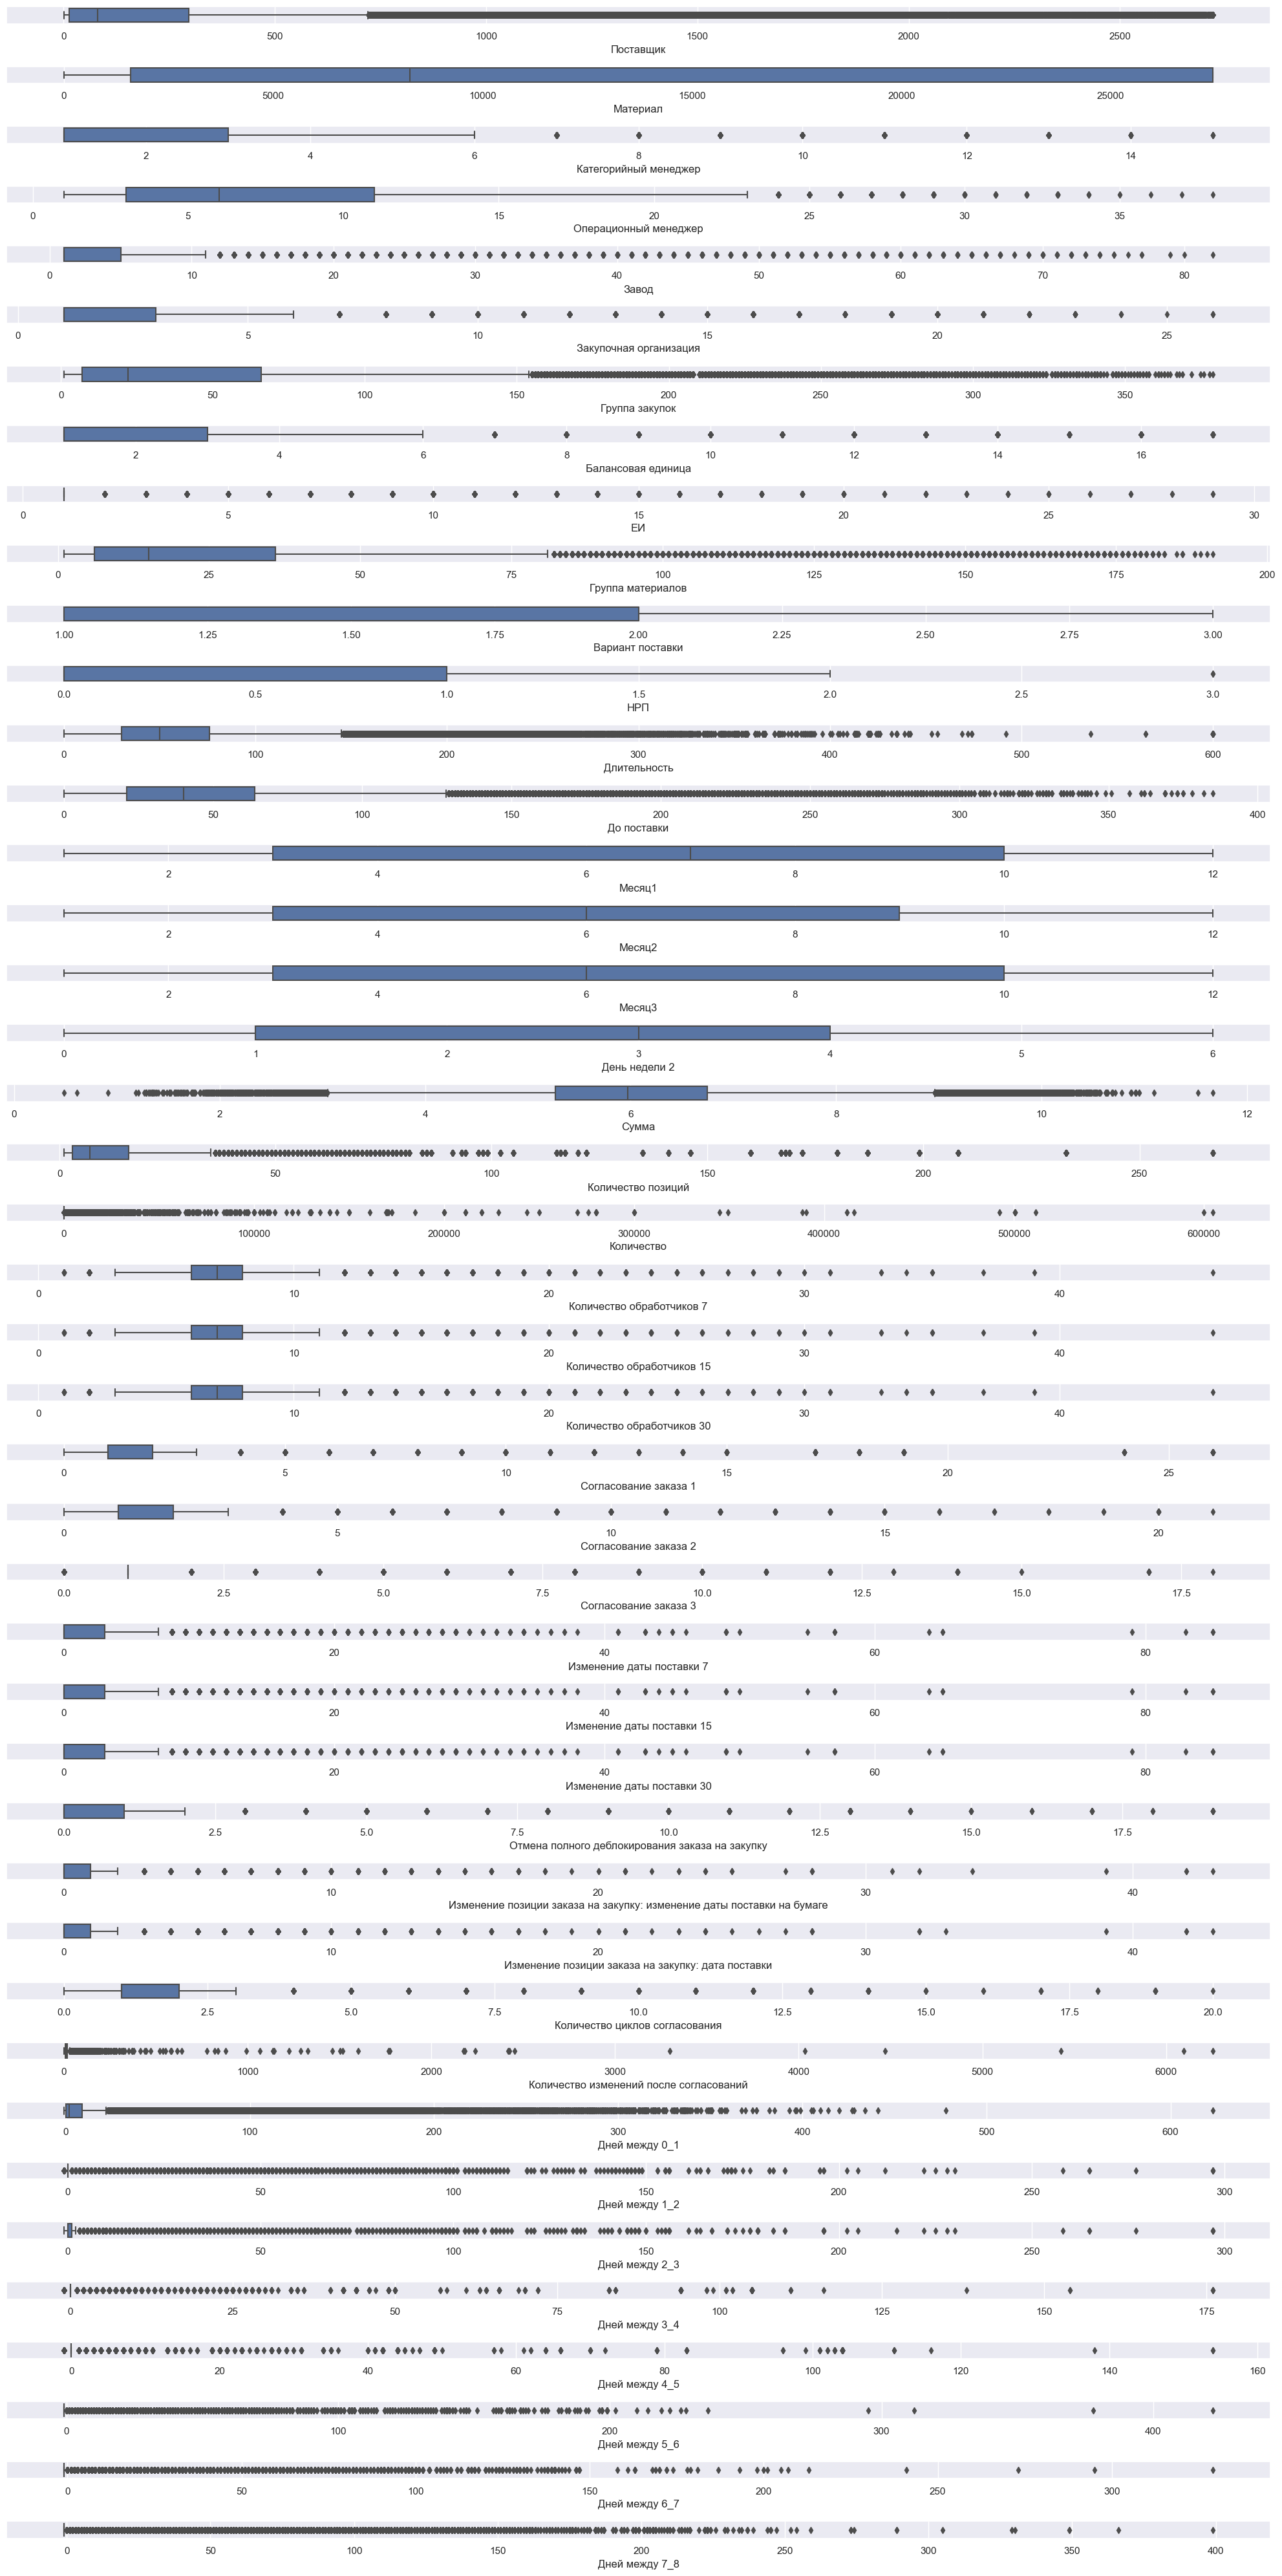

In [75]:
fig, axes = plt.subplots(nrows=len(train_df.columns[:-1]), ncols=1, figsize=(20, 40))
for index, feature in enumerate(train_df.columns[:-1]):
    sns.boxplot(data=train_df, x=feature, hue='y', ax=axes[index])

plt.tight_layout()
plt.show()

## График SHAP 

Для выявления закономерностей мы также можем использовать библиотеку **SHAP**. В качестве оценщика мы будем использовать **LGBMClassifier** из библиотеки **LightGBM**. SHAP является интерепретацией модели, однако позволяет найти действительно существующие закономерности в данных.

In [13]:
# Разделение выборки на тренировочную и тестовую
X, y = train_df.iloc[:, :-1], train_df.iloc[:, -1]   
X.columns = RENAME_COLS
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Создание оверсемпл-датасета (отбор рандомных записей)
oversampler = RandomOverSampler(random_state=42)
X_res, y_res = oversampler.fit_resample(X_train, y_train)

# Параметры модели
parameters = {
    'objective': 'binary',
    'force_row_wise': True,
    'learning_rate': 0.1, 
    'n_estimators': 2000, 
    'max_depth': 18, 
    'max_bin': 256, 
    'num_leaves': 256, 
    'reg_lambda': 0.2, 
    }

# Модель для оценки
model = LGBMClassifier(**parameters, n_jobs=-1)
model.fit(X_res, y_res)


[LightGBM] [Info] Number of positive: 169773, number of negative: 169773
[LightGBM] [Info] Total Bins 3916
[LightGBM] [Info] Number of data points in the train set: 339546, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(force_row_wise=True, max_bin=256, max_depth=18,
               n_estimators=2000, n_jobs=-1, num_leaves=256, objective='binary',
               reg_lambda=0.2)

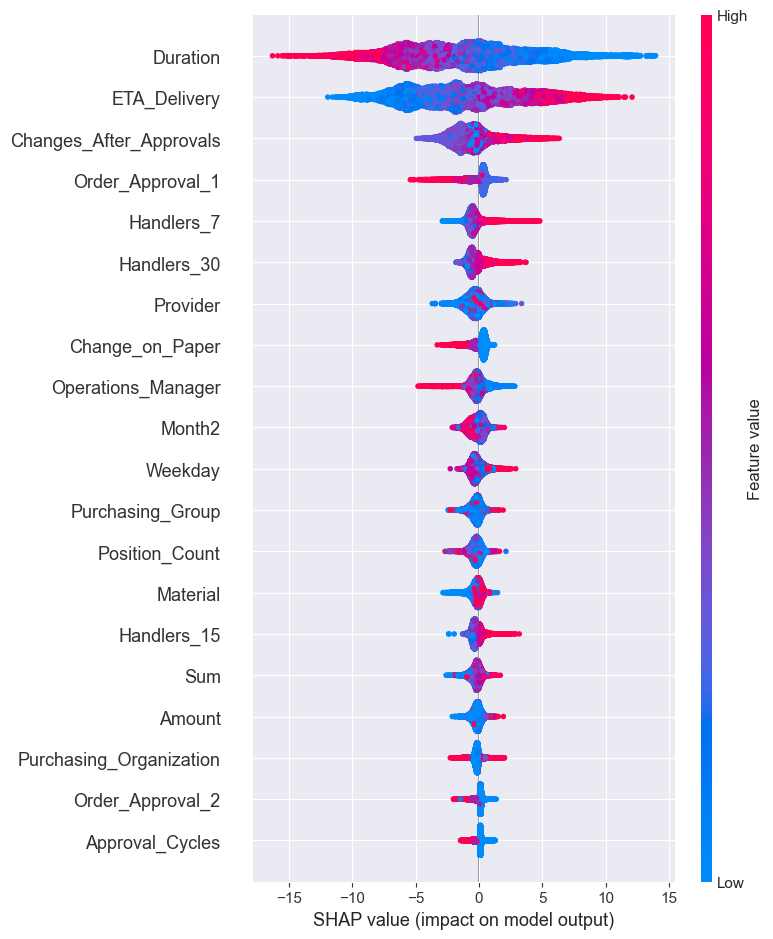

In [14]:
shap_values = shap.TreeExplainer(model).shap_values(X_test)
shap.summary_plot(shap_values[1], X_test)

Из графика SHAP мы видим следующее:
- Чем больше **Длительность** , тем меньше шанс срыва
- Чем больше **До поставки**, тем меньше шанс срыва
- Чем больше **Число изменений после согласований**, тем выше шанс срыва
- Чем меньше **Согласование заказа 1**, тем выше шанс срыва
- Чем больше **Количество обработчиков 7**, тем выше шанс срыва
- Чем больше **Количество обработчиков 30**, тем выше шанс срыва

Всё это необходимо учитывать при построении модели.